##### Copyright 2020 Qiyang Hu

In [0]:
#@title Licensed under MIT License (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://huqy.github.io/idre-learning-deep-learning-pytorch/LICENSE.md
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Import Packages

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
import copy
import tqdm
from PIL import Image
import zipfile

%matplotlib inline

print(torch.__version__)

1.4.0


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Mount Google Drive
For save/load the model

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Download Data from Kaggle

In [5]:
from google.colab import files
files.upload();

Saving kaggle.json to kaggle.json


In [6]:
!mkdir -p /root/.kaggle
!cp kaggle.json /root/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [7]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition -p /content

100% 543M/544M [00:05<00:00, 111MB/s]
100% 544M/544M [00:05<00:00, 111MB/s]
 96% 260M/271M [00:02<00:00, 119MB/s]
100% 271M/271M [00:02<00:00, 106MB/s]
  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 117MB/s]


In [0]:
with zipfile.ZipFile("train.zip","r") as zip_ref:
    zip_ref.extractall("/content/")
with zipfile.ZipFile("test.zip","r") as zip_ref:
    zip_ref.extractall("/content/")

# Import Image Data

In [0]:
train_orig_dir = '/content/train'
train_orig_files = os.listdir(train_orig_dir)

# prepend the absolute path to image files
def train_path(p): return f"/content/train/{p}"
train_orig_files = list(map(train_path, train_orig_files))

In [10]:
min_index_validation = int(len(train_orig_files)/3)*2 # using 1/3 of training data as validation data
train_files = train_orig_files[:min_index_validation]
valid_files = train_orig_files[min_index_validation:]
print(min_index_validation)

16666


In [0]:
class CatDogDataset(Dataset):
    def __init__(self, image_paths, transform):
        super().__init__()
        self.paths = image_paths
        self.len = len(self.paths)
        self.transform = transform
        
    def __len__(self): return self.len
    
    def __getitem__(self, index): 
        path = self.paths[index]
        image = Image.open(path).convert('RGB')
        image = self.transform(image)
        label = 0 if 'cat' in path else 1
        return (image, label)

In [0]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(40, translate=(0.2,0.2), scale=(0.8,1.2), shear=0.2),
    transforms.ToTensor()
])

In [13]:
train_ds = CatDogDataset(train_files, transform)
train_dl = DataLoader(train_ds, batch_size=100, shuffle=True, num_workers=4)
len(train_ds), len(train_dl)

(16666, 167)

In [14]:
valid_ds = CatDogDataset(valid_files, transform)
valid_dl = DataLoader(valid_ds, batch_size=100, shuffle=True, num_workers=4)
len(valid_ds), len(valid_dl)

(8334, 84)

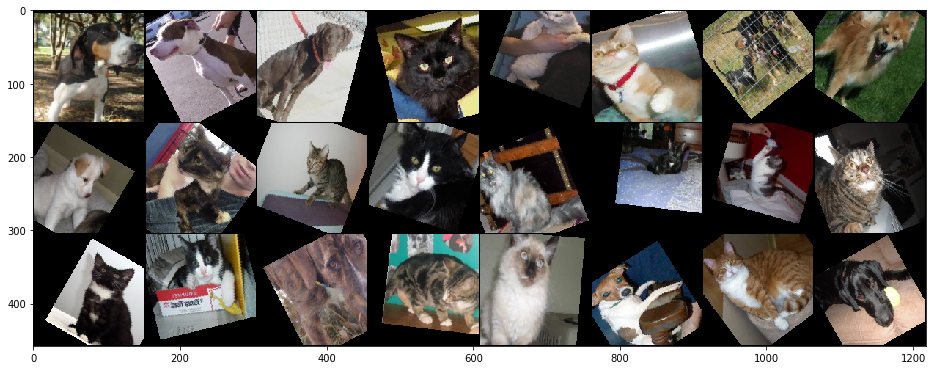

In [15]:
samples, labels = iter(valid_dl).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

# Data Augmentation with own model

## Create the Model

In [0]:
class CatAndDogNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size=(3, 3))
        #self.conv1_dropout = nn.Dropout2d()
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size=(3, 3))
        #self.conv2_dropout = nn.Dropout2d()
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=(3, 3))
        #self.conv3_dropout = nn.Dropout2d()
        self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size=(3, 3))
        self.conv4_dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(in_features= 128 * 7 * 7, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=2)
        
        
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2)
        #X = self.conv1_dropout(X)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2)
        #X = self.conv2_dropout(X)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2)
        #X = self.conv3_dropout(X)
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 2)
        X = self.conv4_dropout(X)

        X = X.view(-1, self.num_flat_features(X))
        X = F.relu(self.fc1(X))

        # Different from Keras, pytorch's nn.CrossEntropyLoss does not need a nn.Softmax(dim=1) in latest layer, because the loss funtion already include softmax function.
        X = self.fc2(X)

        return X

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:       # Get the products
            num_features *= s
        return num_features

In [17]:
model = CatAndDogNet().to(device)
print(model)

CatAndDogNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4_dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


## Train the model

In [0]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [0]:
losses = []
accuracies = []
val_losses = []
val_accuracies = []
EPOCHS = 200
start = time.time()

for epoch in range(EPOCHS):
    epoch_loss = 0
    epoch_accuracy = 0
    for X, y in train_dl:
        # get the inputs
        X = X.to(device)
        y = y.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        preds = model(X)
        loss = loss_fn(preds, y)
        loss.backward()
        optimizer.step()
        
        # print statistics
        accuracy = ((preds.argmax(dim=1) == y).float().mean())
        epoch_accuracy += accuracy
        epoch_loss += loss
        print('.', end='', flush=True)
        
    epoch_accuracy = epoch_accuracy/len(train_dl)
    accuracies.append(epoch_accuracy)
    epoch_loss = epoch_loss / len(train_dl)
    losses.append(epoch_loss)
    print("\nEpoch: {}, train loss: {:.4f}, train accracy: {:.4f}, time: {}".format(epoch, epoch_loss, epoch_accuracy, time.time() - start))


    with torch.no_grad():
        val_epoch_loss = 0
        val_epoch_accuracy = 0
        for val_X, val_y in valid_dl:
            val_X = val_X.to(device)
            val_y = val_y.to(device)
            val_preds = model(val_X)
            val_loss = loss_fn(val_preds, val_y)

            val_epoch_loss += val_loss            
            val_accuracy = ((val_preds.argmax(dim=1) == val_y).float().mean())
            val_epoch_accuracy += val_accuracy
        val_epoch_accuracy = val_epoch_accuracy/len(valid_dl)
        val_accuracies.append(val_epoch_accuracy)
        val_epoch_loss = val_epoch_loss / len(valid_dl)
        val_losses.append(val_epoch_loss)
        print("Epoch: {}, valid loss: {:.4f}, valid accracy: {:.4f}, time: {}\n".format(epoch, val_epoch_loss, val_epoch_accuracy, time.time() - start))

print('Finished Training')

.......................................................................................................................................................................
Epoch: 0, train loss: 0.6929, train accracy: 0.5167, time: 55.01073718070984
Epoch: 0, valid loss: 0.6916, valid accracy: 0.5314, time: 81.63606691360474

.......................................................................................................................................................................
Epoch: 1, train loss: 0.6838, train accracy: 0.5509, time: 137.12121558189392
Epoch: 1, valid loss: 0.6688, valid accracy: 0.5974, time: 163.6910011768341

.......................................................................................................................................................................
Epoch: 2, train loss: 0.6608, train accracy: 0.5958, time: 218.54027700424194
Epoch: 2, valid loss: 0.6499, valid accracy: 0.6116, time: 245.27016282081604

............................

## Visualize the training & validation results

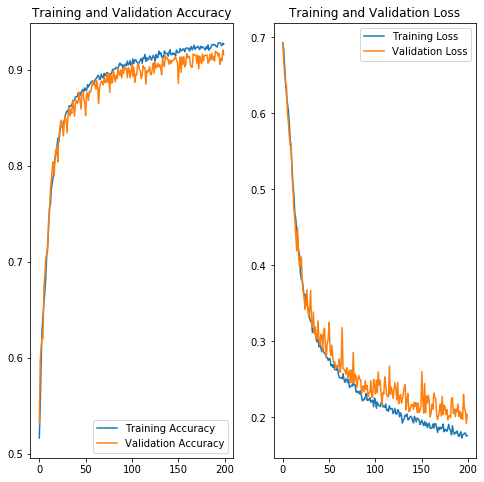

In [0]:
epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()

## Save the model

In [0]:
t = time.time()
savedmodel_dir = "/content/drive/My Drive/saved_model/dogcats_pytorch/plain/{}".format(int(t))
if not os.path.isdir(savedmodel_dir):
    os.makedirs(savedmodel_dir)
filename = 'ckpt_plain_catdog.pth'
filename_pth = os.path.join(savedmodel_dir, filename)
print(filename_pth)

/content/drive/My Drive/saved_model/dogcats_pytorch/plain/1580336561/ckpt_plain_catdog.pth


In [0]:
torch.save(model.state_dict(), filename_pth)

## Load the model

In [0]:
filename_pth = '/content/drive/My Drive/saved_model/dogcats_pytorch/plain/1580336561/ckpt_plain_catdog.pth'

In [20]:
model = CatAndDogNet().to(device)
model.load_state_dict(torch.load(filename_pth))
model.eval()

CatAndDogNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4_dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

## Predict the model

### Prepare the test data

In [0]:
test_dir = '/content/test'
test_files = os.listdir(test_dir)

def test_path(p): return f"/content/test/{p}"
test_files = list(map(test_path, test_files))

In [0]:
test_transform = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor()
])

In [0]:
class TestCatDogDataset(Dataset):
    def __init__(self, image_paths, transform):
        super().__init__()
        self.paths = image_paths
        self.len = len(self.paths)
        self.transform = transform
        
    def __len__(self): return self.len
    
    def __getitem__(self, index): 
        path = self.paths[index]
        image = Image.open(path).convert('RGB')
        image = self.transform(image)
        fileid = path.split('/')[-1].split('.')[0]
        return (image, fileid)

In [24]:
test_ds = TestCatDogDataset(test_files, test_transform)
test_dl = DataLoader(test_ds, batch_size=100)
len(test_ds), len(test_dl)

(12500, 125)

### Predict the test dataset

In [0]:
fn_list = []
pred_list = []
with torch.no_grad():
    for X, fileid in test_dl:
        X = X.to(device)
        preds = model(X)
        fn_list += fileid
        pred_list += F.softmax(preds, dim=1)[:,1].tolist()
        
submission = pd.DataFrame({"id":fn_list, "label":pred_list})


In [26]:
submission.head()

,id,label
0,7314,0.964803
1,6540,0.999610
2,9460,0.534932
3,7782,0.914913
4,11935,0.984834


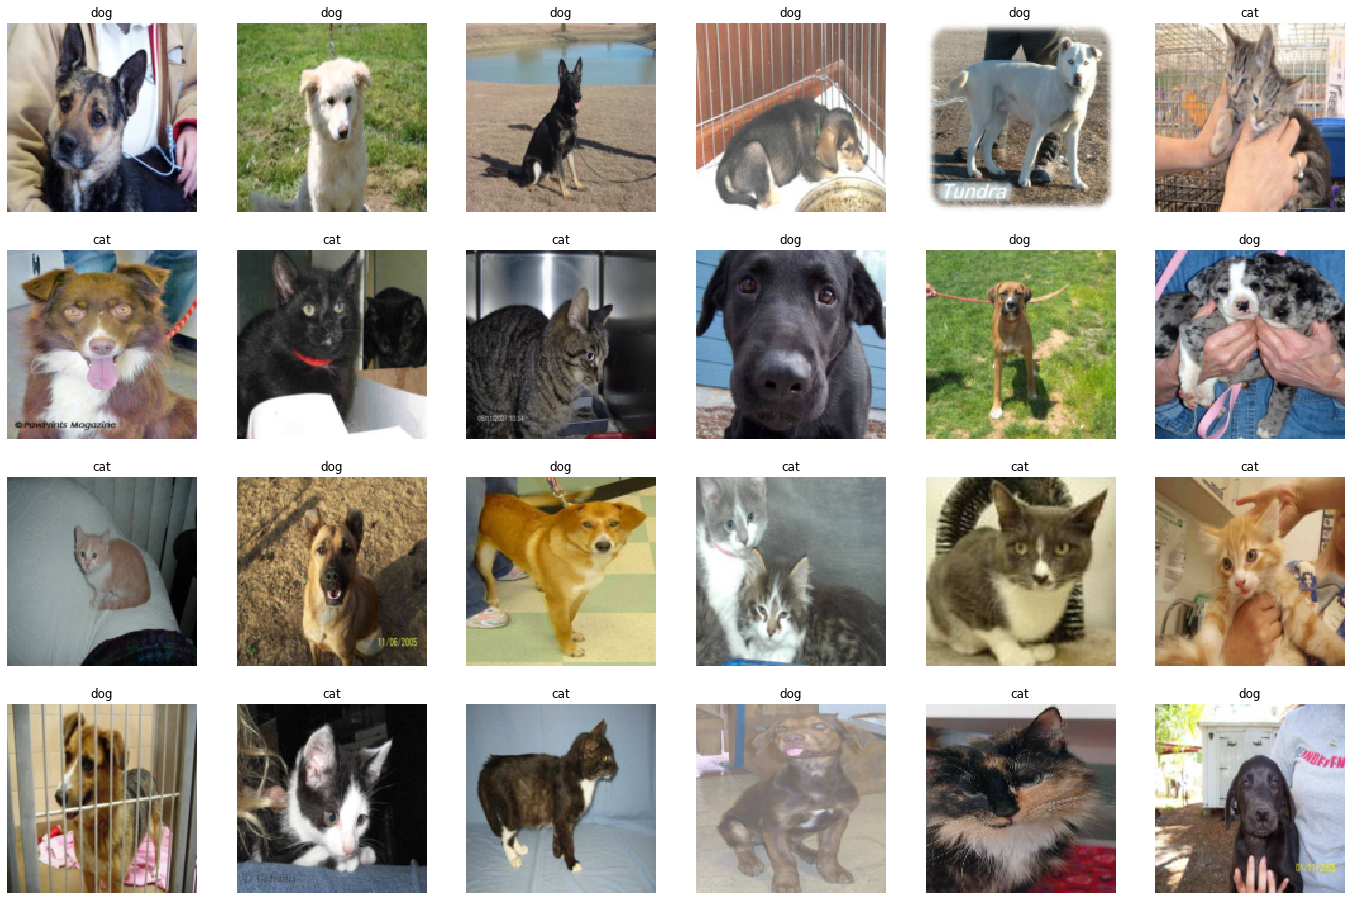

In [27]:
samples, _ = iter(test_dl).next()
#samples = samples.to(device)
fig = plt.figure(figsize=(24, 16))
fig.tight_layout()
#output = model(samples[:24])
output = submission[:24]['label']
#pred = torch.argmax(output, dim=1)
#pred = [p.item() for p in pred]
#ad = {0:'cat', 1:'dog'}
for num, sample in enumerate(samples[:24]):
    category = "dog" if submission.iloc[num,:]['label'] >= 0.5 else "cat"
    plt.subplot(4,6,num+1)
    plt.title(category)
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))

# Submission to Kaggle

NOTE: Before submission, you need to re-run the notebook using the whole set of training files without validation set to get a better result.

In [0]:
submission.to_csv('preds.csv', index=False)

In [0]:
!kaggle competitions submit -c dogs-vs-cats-redux-kernels-edition -f preds.csv -m "My first pytorch submission without data augmentation"

# Transfer Learning Approach

In [28]:
#model = torchvision.models.densenet121(pretrained=True)
#model = torchvision.models.vgg16(pretrained=True)
model = torch.hub.load('pytorch/vision:v0.4.2', 'mobilenet_v2', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.4.2.zip" to /root/.cache/torch/hub/v0.4.2.zip
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth


In [29]:
print(model.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


In [0]:
## Freeze model weights (Freezing weights doesn't give better results in this case!)
#for param in model.parameters():
#    param.requires_grad = False

In [0]:
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)

In [0]:
# Another options for the classification layer, no significant difference though.
model.classifier[1] = nn.Sequential(
    nn.Linear(1280, 500),
    nn.ReLU(), 
    nn.Dropout(0.4),
    nn.Linear(500, 2)
)

In [32]:
print(model.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Sequential(
    (0): Linear(in_features=1280, out_features=500, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=500, out_features=2, bias=True)
  )
)


In [33]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

2,865,374 total parameters.
2,865,374 training parameters.


In [0]:
model = model.to(device)

In [0]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.002, amsgrad=True)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500,1000,1500], gamma=0.5)

In [37]:
losses = []
accuracies = []
val_losses = []
val_accuracies = []
EPOCHS = 5
start = time.time()

for epoch in range(EPOCHS):
    epoch_loss = 0
    epoch_accuracy = 0
    for X, y in train_dl:
        # get the inputs
        X = X.to(device)
        y = y.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        preds = model(X)
        loss = loss_fn(preds, y)
        loss.backward()
        optimizer.step()
        
        # print statistics
        accuracy = ((preds.argmax(dim=1) == y).float().mean())
        epoch_accuracy += accuracy
        epoch_loss += loss
        print('.', end='', flush=True)
        
    epoch_accuracy = epoch_accuracy/len(train_dl)
    accuracies.append(epoch_accuracy)
    epoch_loss = epoch_loss / len(train_dl)
    losses.append(epoch_loss)
    print("\nEpoch: {}, train loss: {:.4f}, train accracy: {:.4f}, time: {}".format(epoch, epoch_loss, epoch_accuracy, time.time() - start))


    with torch.no_grad():
        val_epoch_loss = 0
        val_epoch_accuracy = 0
        for val_X, val_y in valid_dl:
            val_X = val_X.to(device)
            val_y = val_y.to(device)
            val_preds = model(val_X)
            val_loss = loss_fn(val_preds, val_y)

            val_epoch_loss += val_loss            
            val_accuracy = ((val_preds.argmax(dim=1) == val_y).float().mean())
            val_epoch_accuracy += val_accuracy
        val_epoch_accuracy = val_epoch_accuracy/len(valid_dl)
        val_accuracies.append(val_epoch_accuracy)
        val_epoch_loss = val_epoch_loss / len(valid_dl)
        val_losses.append(val_epoch_loss)
        print("Epoch: {}, valid loss: {:.4f}, valid accracy: {:.4f}, time: {}\n".format(epoch, val_epoch_loss, val_epoch_accuracy, time.time() - start))

print('Finished Training')

.......................................................................................................................................................................
Epoch: 0, train loss: 0.1937, train accracy: 0.9201, time: 68.2146680355072
Epoch: 0, valid loss: 0.1615, valid accracy: 0.9360, time: 98.93485140800476

.......................................................................................................................................................................
Epoch: 1, train loss: 0.1451, train accracy: 0.9417, time: 166.48541140556335
Epoch: 1, valid loss: 0.1356, valid accracy: 0.9464, time: 196.96689248085022

.......................................................................................................................................................................
Epoch: 2, train loss: 0.1245, train accracy: 0.9481, time: 264.4000873565674
Epoch: 2, valid loss: 0.1320, valid accracy: 0.9498, time: 294.63492131233215

.............................

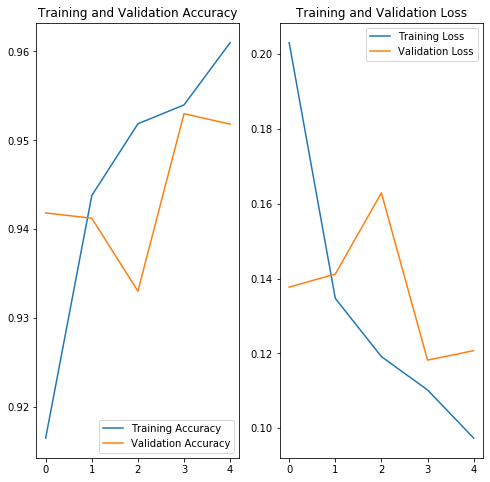

In [0]:
epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()

In [0]:
t = time.time()
savedmodel_dir = "/content/drive/My Drive/saved_model/dogcats_pytorch/plain/{}".format(int(t))
if not os.path.isdir(savedmodel_dir):
    os.makedirs(savedmodel_dir)
filename = 'ckpt_plain_catdog.pth'
filename_pth = os.path.join(savedmodel_dir, filename)
print(filename_pth)

/content/drive/My Drive/saved_model/dogcats_pytorch/plain/1580497637/ckpt_plain_catdog.pth


In [0]:
torch.save(model.state_dict(), filename_pth)

In [0]:
filename_pth = '/content/drive/My Drive/saved_model/dogcats_pytorch/plain/1580497637/ckpt_plain_catdog.pth'

In [0]:
model.load_state_dict(torch.load(filename_pth))
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr